<a href="https://colab.research.google.com/github/prasadanilmore/CNN-Project-Leaf-Classification/blob/main/CNN_Leaf_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

In [3]:
os.chdir("/content/drive/MyDrive/ML projects/Leaf disease classification")

In [4]:
pwd

'/content/drive/MyDrive/ML projects/Leaf disease classification'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Data Preparation

Importing all the modules

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Variable
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
    )

Found 1034 files belonging to 3 classes.


In [8]:
len(dataset)

33

In [11]:
class_names = dataset.class_names

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 2 0 2 0 0 2 2 2 1 0 0 1 1 1 0 2 2 2 2 0 0 2 0 2 2 2 2 2 0 0]


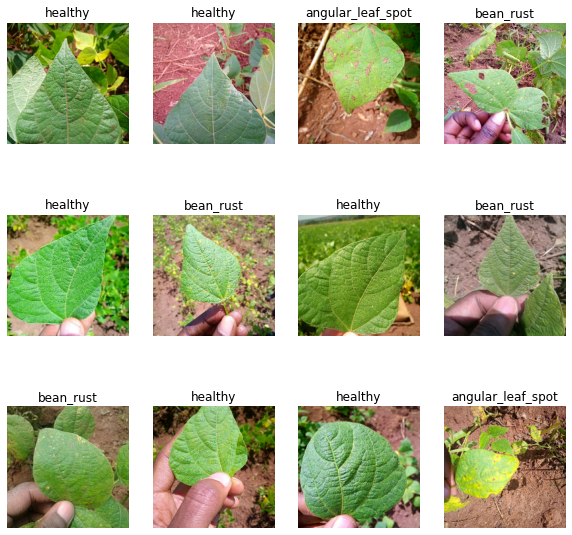

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Functions declarations

In [14]:
# def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1 ,test_split= 0.1, shuffle = True, shuffle_size = 10000):
#   assert (train_split + test_split + val_split) == 1
#   ds_size = len(ds)

#   if shuffle:
#     ds = ds.shuffle(shuffle_size, seed = 12)

#   # taking percent of elements of ds in train, validation, test
#   train_size = int(train_split*ds_size)
#   val_size = int(val_split*ds_size)
#   test_size = int(test_split*ds_size)

#   # allocation sample size to datasets
#   train_ds = ds.take(train_size)
#   val_ds = ds.skip(train_size).take(val_size)
#   test_ds = ds.skip(train_size).skip(val_size)

#   return train_ds, val_ds, test_ds

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


Datasets

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

26

Cache, Shuffle, and Prefetch the Dataset.
this runs the reading and training batches simultaneouly... and does processing in less time

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Resizing = Adding the resizing layer to the model, so that a new input image od any size will be brought to the standard size by this layer

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

Data Augemntation: Creating 4 images from 1 with flip, crop, quality

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")

])

Applying Data augmentation to the training dataset

In [20]:
train_ds = train_ds.map(lambda x,y : (data_augmentation(x, training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the CNN Model

Model Building

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    # First layer Resize and rescale
    resize_and_rescale,
    # Convolution and relu Layer
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    # Pooling of first layer
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


Summary of the model

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

Compiling Model: used "Adam" Optimizer and "SparseCategoricalCategory" for loss functions and "accuracy" as a metric

In [23]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

To get the history of every Epoch

In [24]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    batch_size = BATCH_SIZE,
    verbose=1,
    epochs=50
)

Epoch 1/50
26/26 [==============================] - 103s 4s/step - loss: 1.0987 - accuracy: 0.3679 - val_loss: 1.0850 - val_accuracy: 0.3646
Epoch 2/50
26/26 [==============================] - 89s 3s/step - loss: 1.0367 - accuracy: 0.4543 - val_loss: 1.1460 - val_accuracy: 0.4271
Epoch 3/50
26/26 [==============================] - 92s 4s/step - loss: 1.0118 - accuracy: 0.5049 - val_loss: 0.9718 - val_accuracy: 0.5417
Epoch 4/50
26/26 [==============================] - 91s 3s/step - loss: 0.9159 - accuracy: 0.5815 - val_loss: 0.8962 - val_accuracy: 0.5625
Epoch 5/50
26/26 [==============================] - 89s 3s/step - loss: 0.9014 - accuracy: 0.5926 - val_loss: 0.9169 - val_accuracy: 0.5521
Epoch 6/50
26/26 [==============================] - 89s 3s/step - loss: 0.8384 - accuracy: 0.6346 - val_loss: 0.8519 - val_accuracy: 0.6146
Epoch 7/50
26/26 [==============================] - 89s 3s/step - loss: 0.8027 - accuracy: 0.6778 - val_loss: 0.8871 - val_accuracy: 0.6250
Epoch 8/50
26/26 [=

In [25]:

scores = model.evaluate(test_ds)

4/4 [==============================] - 11s 867ms/step - loss: 0.3164 - accuracy: 0.8828


Accuracy is 88%

In [26]:
scores


[0.31640544533729553, 0.8828125]

Plotting the Accuracy and Loss Curves

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 26}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
len(history.history['loss'])

50

In [30]:

history.history['loss'][:5] # show loss for first 5 epochs

[1.0987218618392944,
 1.036736249923706,
 1.0117621421813965,
 0.9159043431282043,
 0.9014151096343994]

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']



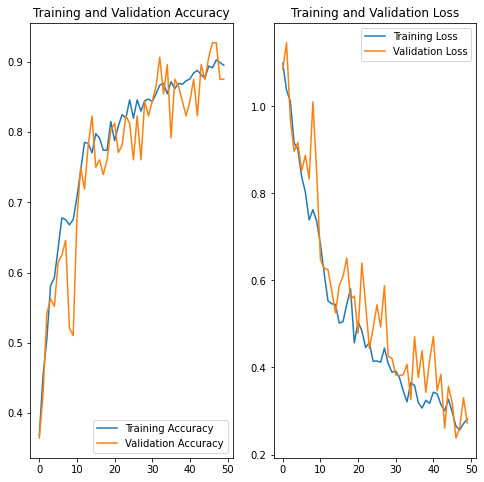

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: healthy
1/1 [==============================] - 1s 897ms/step
predicted label: healthy


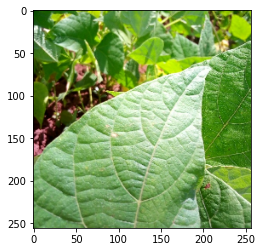

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])



In [36]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 56ms/step


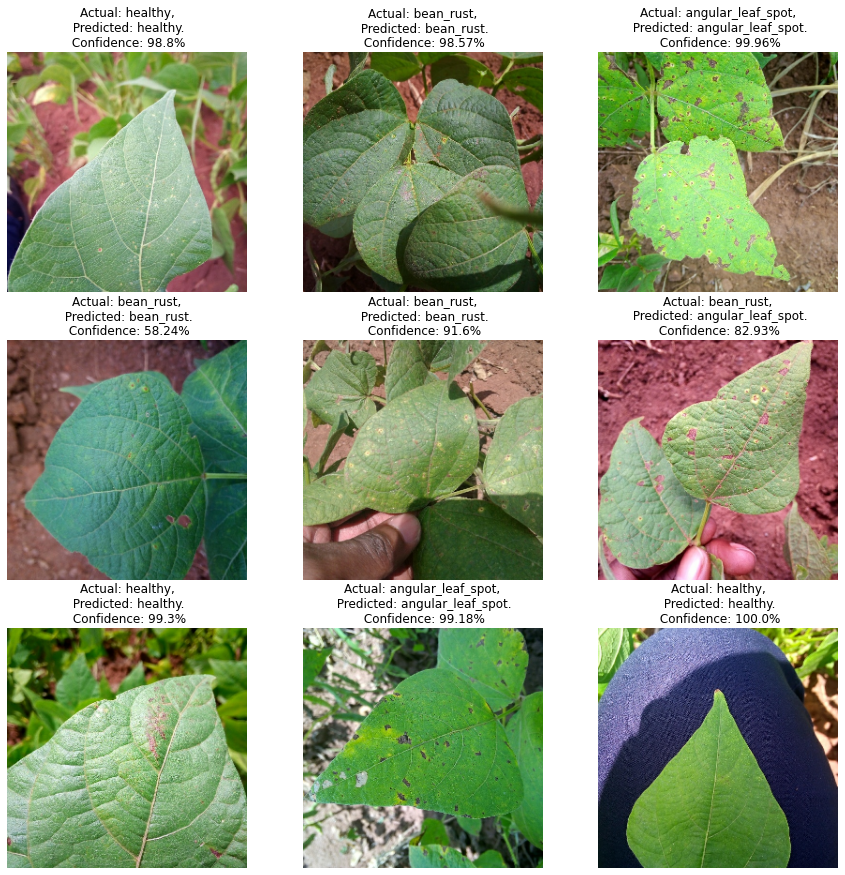

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")


In [38]:
model_name = "CNN Leaf Model 1"
model.save(f"/Models/{model_name}")


In [40]:
model.save(f"../Models/{model_name}")